## Importing Libraries:
Below are the necessary libraries that we are importing. Essentially I picked a well known model from huggingface and then I simply downloaded it and set it up locally on my device.

In [1]:
import os

# trying to use the G drive if it exists . . .
if os.path.exists("G:/huggingface"):
    base_dir = "G:/huggingface"
else:
    # fallback to current directory . . .
    print("G drive not found, using current directory")
    base_dir = os.path.join(os.getcwd(), "huggingface")

# setting all the environment variables . . .
os.environ["HF_HOME"] = base_dir
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(base_dir, "hub_cache")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(base_dir, "transformers")
os.environ["DIFFUSERS_CACHE"] = os.path.join(base_dir, "diffusers")
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# making sure base_dir exists . . .
os.makedirs(base_dir, exist_ok=True)

In [2]:
from huggingface_hub import InferenceClient
from huggingface_hub import login
from diffusers import StableDiffusionPipeline
from dotenv import load_dotenv
import torch
import threading
import requests
import time
import matplotlib.pyplot as plt
from datetime import datetime

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
# local setup . . .
load_dotenv()  # basically this loads .env file variables into environment . . .

token = os.getenv("HF_TOKEN")
login(token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# !pip install diffusers transformers accelerate safetensors scipy

## Setting up Model:
Picked this well known model called stable-diffusion-v1-5 from hugging face and then essentially I downloaded it (set it up locally so no API dependency). After that, I have tested it within this notebook. Since for this project I am using CPU, it takes 3-4 minutes to generate an image. However, using CUDA we could realistically make it faster.

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    use_safetensors=True,
    cache_dir=base_dir
)
pipe = pipe.to("cpu")

Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.40it/s]


## Testing the Model:
Simple prompts to see how the model behaves and then saving the result images within G disk

In [6]:
prompt = "pink flower"
image = pipe(prompt).images[0]

# displaying the generated image . . .
image.show()

# saving it to a file . . .
# image.save("G:/huggingface/anime.png")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:40<00:00,  6.81s/it]


## Postman Test Collection

We created and tested a Postman collection to validate our `/generate` FastAPI endpoint.  
It was exported as:

**Text2Image API..postman_collection.json**

It includes tests for:
- Small prompt
- Empty prompt (edge case)
- Large detailed prompt (stress case)

The collection is included in the project repository.

### Test Case Summary

| Test Name         | Prompt (shortened)                                 | Purpose                              | Expected Outcome             | Result |
|-------------------|----------------------------------------------------|--------------------------------------|------------------------------|--------|
| Small Prompt Test | "the night city from cyberpunk"                    | Normal functional prompt             | Image is generated           | ✅     |
| Empty Prompt Test | ""                                                 | Test invalid empty input             | 422 Unprocessable Entity     | ✅     |
| Big Prompt Test   | "draw a fantasy world with flying dragons..."      | Test long descriptive input          | Image is generated or slower | ✅     |


## Screenshots From Postman:
Displaying the screenshots below:

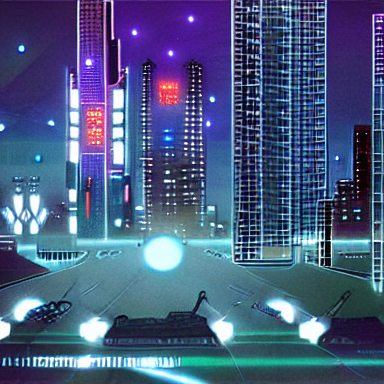

In [7]:
from IPython.display import Image, display

# image 1: small prompt test case
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\1745857383.4400554.png"))

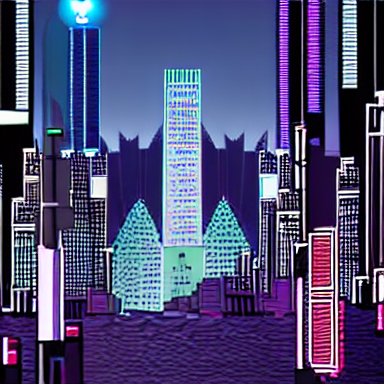

In [8]:
# re-entered the same prompt (test case 1)

# image 1: small prompt test case
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\1746116708.18624.png"))

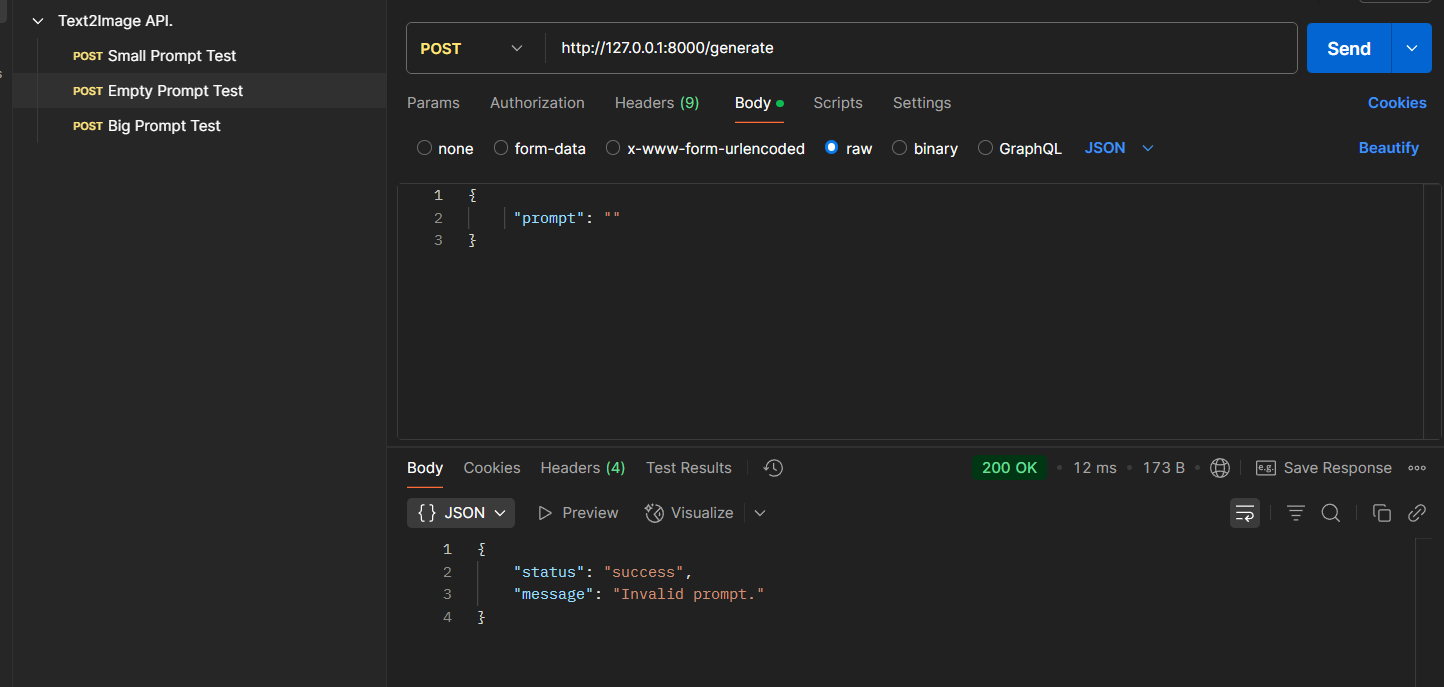

In [9]:
# test case 2 - Empty Prompt:
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\Screenshot 2025-05-01 212557.png"))

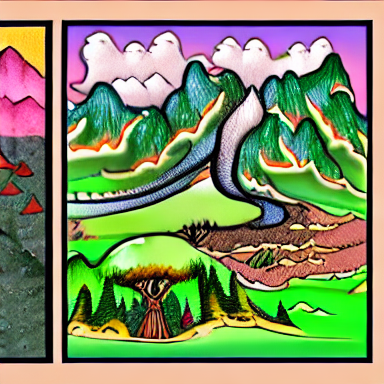

In [10]:
# test case 3 - big prompt:
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\1745857896.9881282.png"))

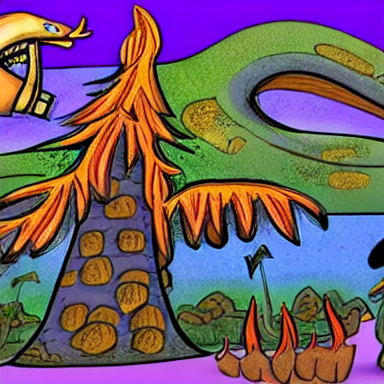

In [11]:
# test case 3 - big prompt:
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\1746116865.699268.png"))

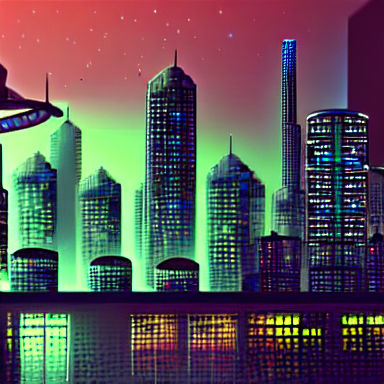

In [12]:
# some more random images generated:
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\1745613115.8994393.png"))

## Screenshots From Postman:
Below are the screenshots from postman:

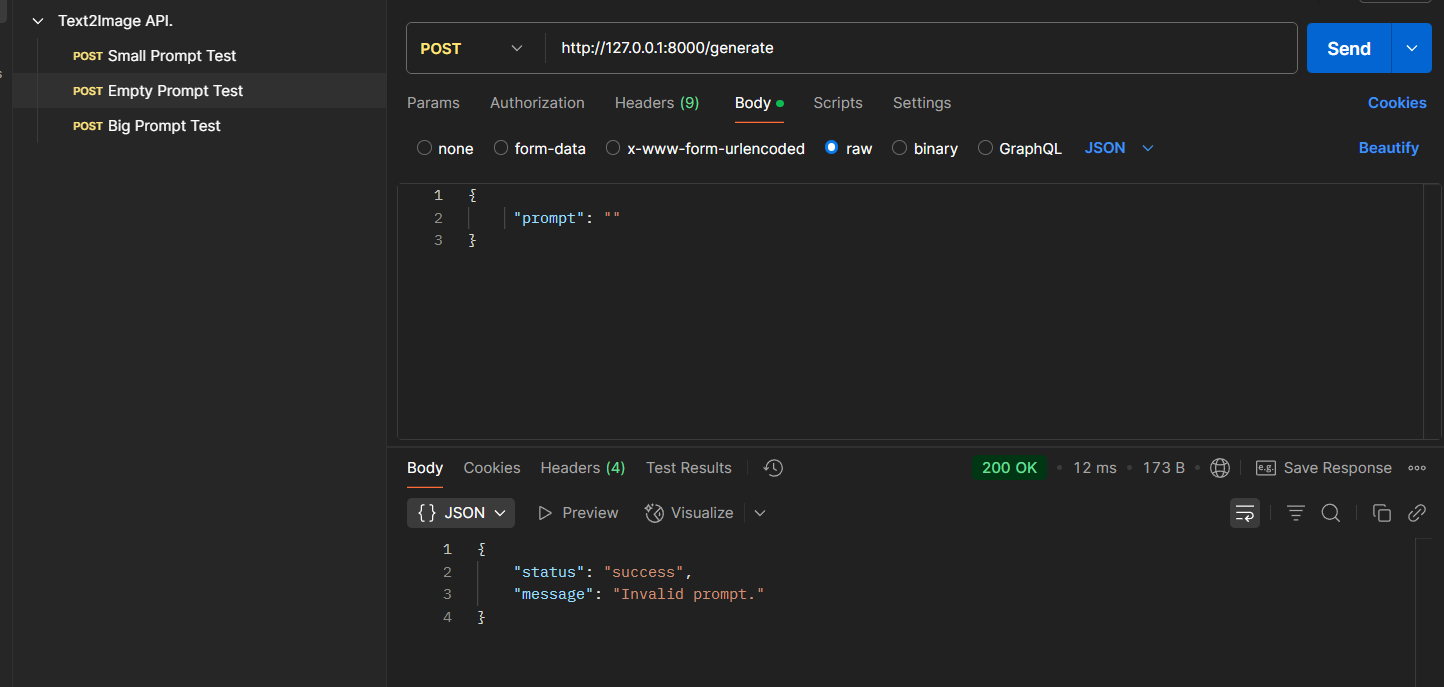

In [13]:
# 1. empty prompt:
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\Screenshot 2025-05-01 212557.png"))

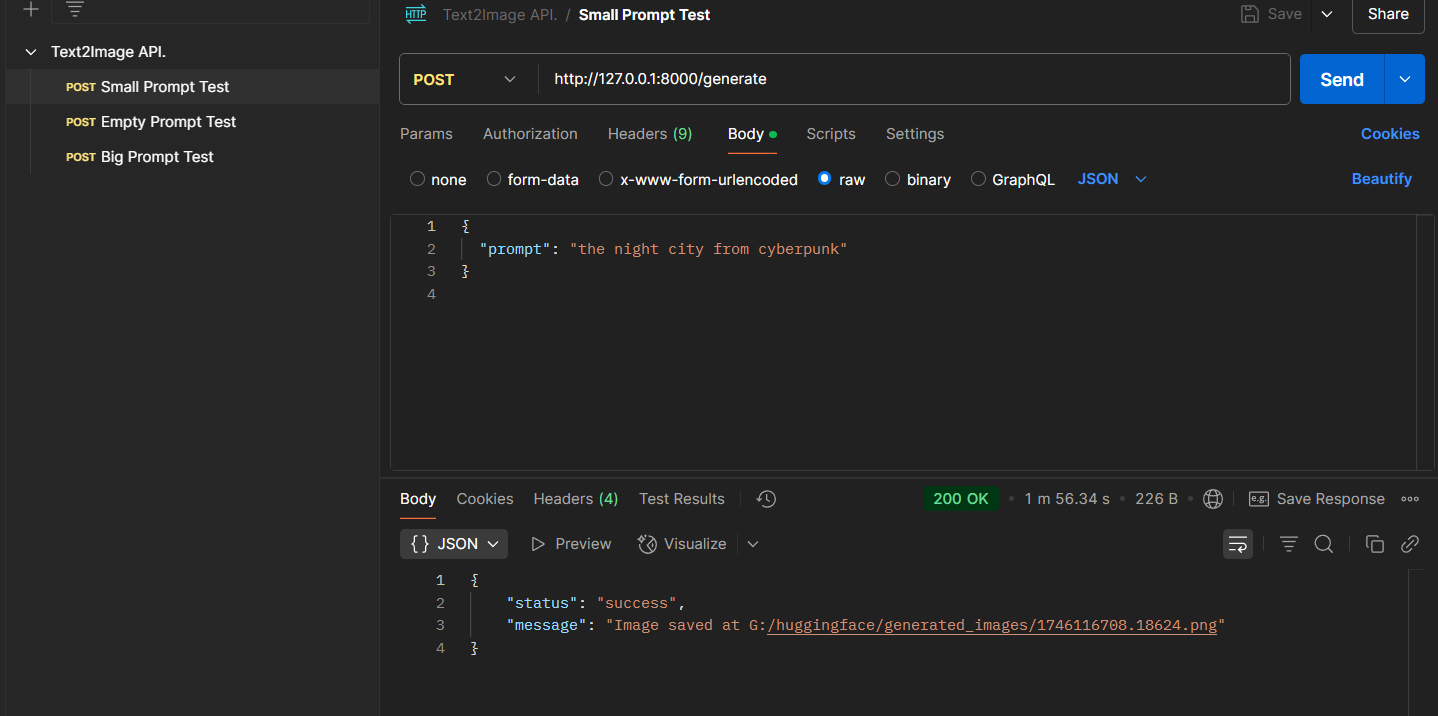

In [14]:
# 2. small prompt:
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\Screenshot 2025-05-01 212519.png"))

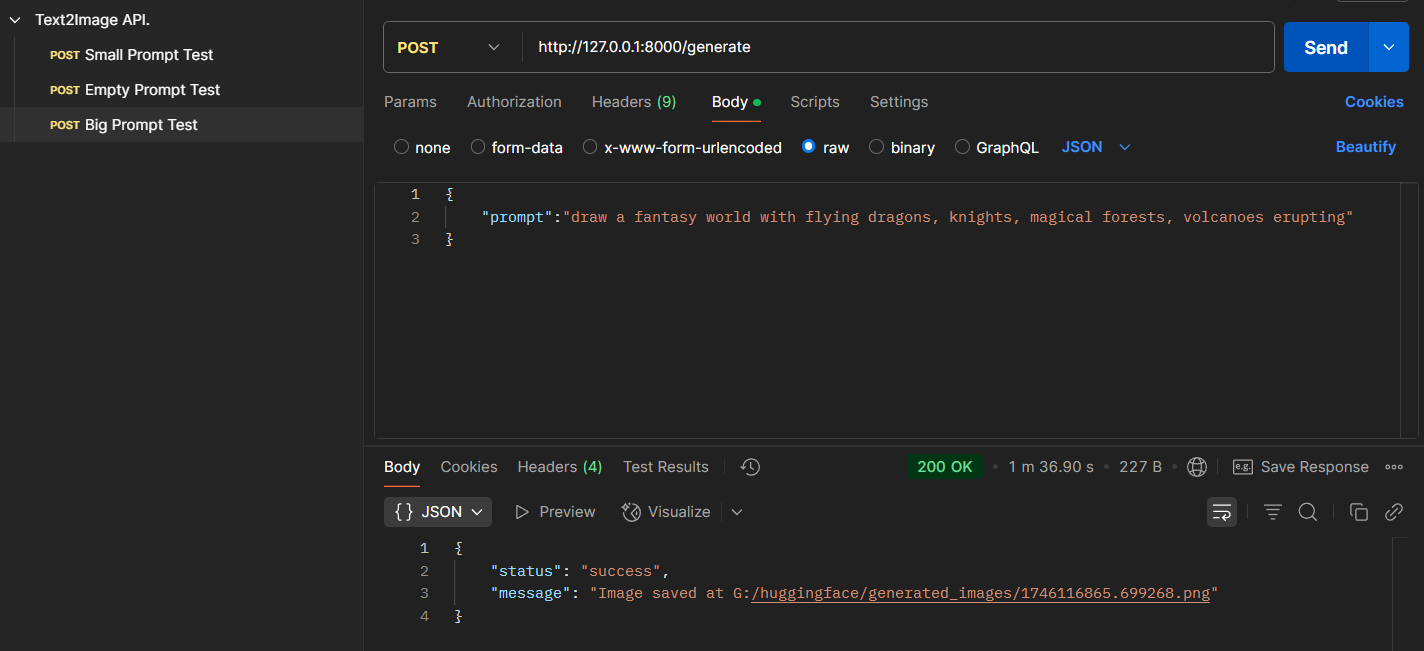

In [15]:
# 3. big prompt:
display(Image(filename="C:\\Users\\HP\\Downloads\\Untitled Folder 13\\images\\Screenshot 2025-05-01 212756.png"))

## Performance Graph:
Now simulating single request, multiple requests etc and making respective performance graphs

In [6]:
# making a function to hit the end points:

pipe_lock = threading.Lock()  # to avoid model access overlap . . .

def send_request(prompt="the night city from cyberpunk"):
    url = "http://127.0.0.1:8000/generate"
    payload = {"prompt": prompt}
    start_time = time.time()
    
    try:
        
        with pipe_lock:  # simply protects model access . . .
            response = requests.post(url, json=payload)
        elapsed = time.time() - start_time
        
        return elapsed
    
    except Exception as e:
        print("Request failed:", e)
        return None

In [7]:
# function to simulate concurrent users . . .

def run_concurrent_requests(n_users):
    
    times = []

    def worker():
        t = send_request()
        if t is not None:
            times.append(t)

    threads = []
    
    for _ in range(n_users):
        thread = threading.Thread(target=worker)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    print(f"Individual times for {n_users} users:", times)
    
    return sum(times) / len(times) if times else None

In [8]:
# collecting the data . . .

user_counts = [1, 3, 5]
avg_times = []

print("Warming up the model...")
send_request("Warming up Stable Diffusion...")
print("Warmup done\n")

for count in user_counts:
    print(f"Running with {count} users...")
    avg_time = run_concurrent_requests(count)
    
    if avg_time is not None:
        print(f"Average time: {avg_time:.2f} seconds\n")
    else:
        print("Failed to get average time.\n")
    
    avg_times.append(avg_time)

Warming up the model...
Warmup done

Running with 1 users...
Individual times for 1 users: [78.1434154510498]
Average time: 78.14 seconds

Running with 3 users...
Individual times for 3 users: [78.60176730155945, 156.7888629436493, 234.95610785484314]
Average time: 156.78 seconds

Running with 5 users...
Individual times for 5 users: [78.49473977088928, 156.54812169075012, 234.630441904068, 312.8633704185486, 391.0876669883728]
Average time: 234.72 seconds



Graph saved as performance_graph_2025-05-01_22-39-31.png


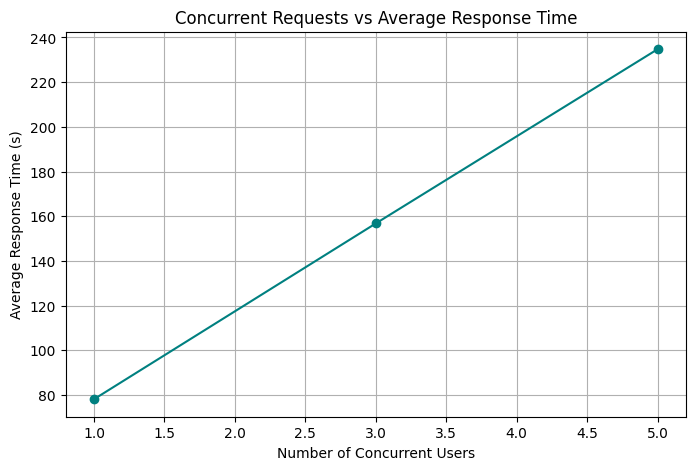

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(user_counts, avg_times, marker='o', color='teal')
plt.title("Concurrent Requests vs Average Response Time")
plt.xlabel("Number of Concurrent Users")
plt.ylabel("Average Response Time (s)")
plt.grid(True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"performance_graph_{timestamp}.png"
plt.savefig(filename)

print(f"Graph saved as {filename}")
plt.show()

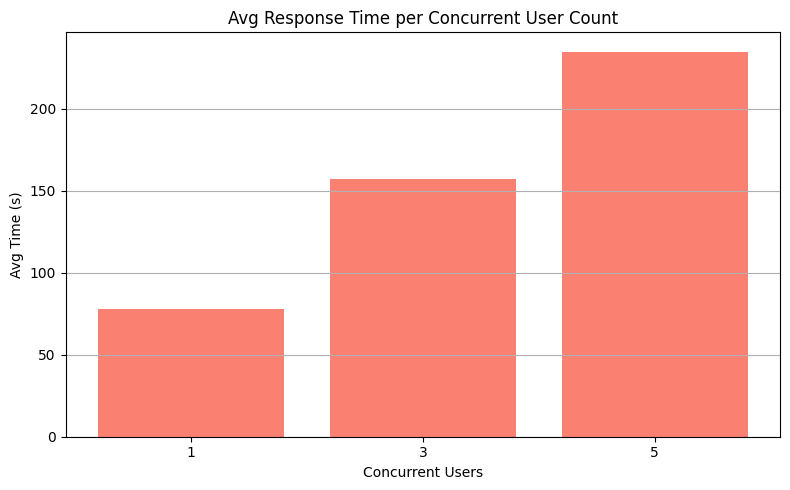

In [10]:
# Making a bar graph too . . .
plt.figure(figsize=(8, 5))
plt.bar([str(u) for u in user_counts], avg_times, color='salmon')
plt.title("Avg Response Time per Concurrent User Count")
plt.xlabel("Concurrent Users")
plt.ylabel("Avg Time (s)")
plt.grid(axis='y')
plt.tight_layout()

plt.savefig("bar_graph.png")
plt.show()